In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qiskit.circuit.library import n_local, RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
from qiskit_optimization.optimizers import SPSA, COBYLA
from qiskit_optimization.utils import algorithm_globals

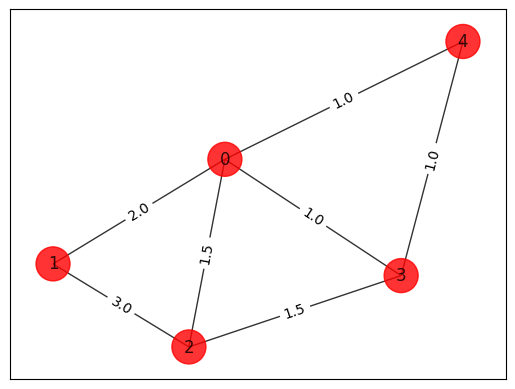

In [2]:
n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 2.0), (0, 2, 1.5), (0, 3, 1.0), (1, 2, 3.0), (2, 3, 5.0),(3,2,1.5),(3,4,1.0),(4,0,1.0)]  # edge list; each element in the
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [3]:

# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0.  2.  1.5 1.  1. ]
 [2.  0.  3.  0.  0. ]
 [1.5 3.  0.  1.5 0. ]
 [1.  0.  1.5 0.  1. ]
 [1.  0.  0.  1.  0. ]]


case = [0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0] cost = 5.5
case = [0, 1, 0, 0, 0] cost = 5.0
case = [1, 1, 0, 0, 0] cost = 6.5
case = [0, 0, 1, 0, 0] cost = 6.0
case = [1, 0, 1, 0, 0] cost = 8.5
case = [0, 1, 1, 0, 0] cost = 5.0
case = [1, 1, 1, 0, 0] cost = 3.5
case = [0, 0, 0, 1, 0] cost = 3.5
case = [1, 0, 0, 1, 0] cost = 7.0
case = [0, 1, 0, 1, 0] cost = 8.5
case = [1, 1, 0, 1, 0] cost = 8.0
case = [0, 0, 1, 1, 0] cost = 6.5
case = [1, 0, 1, 1, 0] cost = 7.0
case = [0, 1, 1, 1, 0] cost = 5.5
case = [1, 1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 0, 1] cost = 5.5
case = [0, 1, 0, 0, 1] cost = 7.0
case = [1, 1, 0, 0, 1] cost = 6.5
case = [0, 0, 1, 0, 1] cost = 8.0
case = [1, 0, 1, 0, 1] cost = 8.5
case = [0, 1, 1, 0, 1] cost = 7.0
case = [1, 1, 1, 0, 1] cost = 3.5
case = [0, 0, 0, 1, 1] cost = 3.5
case = [1, 0, 0, 1, 1] cost = 5.0
case = [0, 1, 0, 1, 1] cost = 8.5
case = [1, 1, 0, 1, 1] cost = 6.0
case = [0, 0, 1, 1, 1] cost = 6.5
case = [1, 0, 

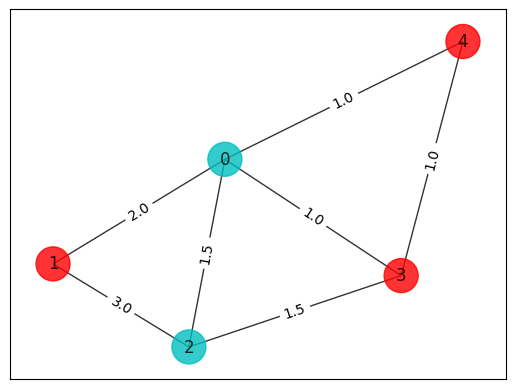

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -4*x_0*x_1 - 3*x_0*x_2 - 2*x_0*x_3 - 2*x_0*x_4 - 6*x_1*x_2 - 3*x_2*x_3
  - 2*x_3*x_4 + 5.5*x_0 + 5*x_1 + 6*x_2 + 3.5*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



In [6]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -5.5
Ising Hamiltonian:
SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.  +0.j, 0.75+0.j, 0.5 +0.j, 0.5 +0.j, 1.5 +0.j, 0.75+0.j, 0.5 +0.j])


In [7]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 8.5
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0
status: SUCCESS


energy: -3.0000000000000058
max-cut objective: -8.500000000000005
solution: [0. 1. 0. 1. 1.]
solution objective: 8.5


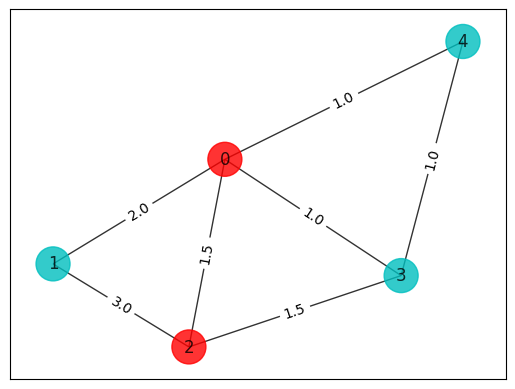

In [8]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [9]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -2.9931640625
time: 2.7712457180023193
max-cut objective: -8.4931640625
solution: [0 1 0 1 0]
solution objective: 8.5


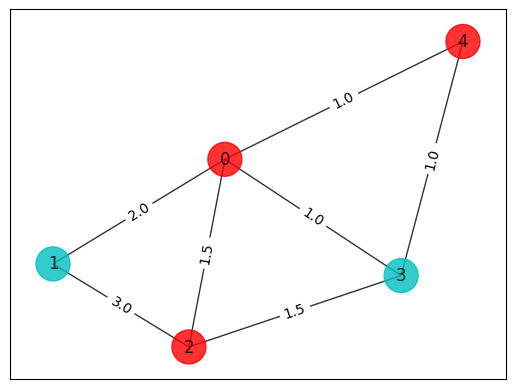

In [10]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ansatz = n_local(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=StatevectorSampler(seed=123), ansatz=ansatz, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

energy: -3.0
time: 2.7644569873809814
max-cut objective: -8.5
solution: [1 0 1 0 1]
solution objective: 8.5


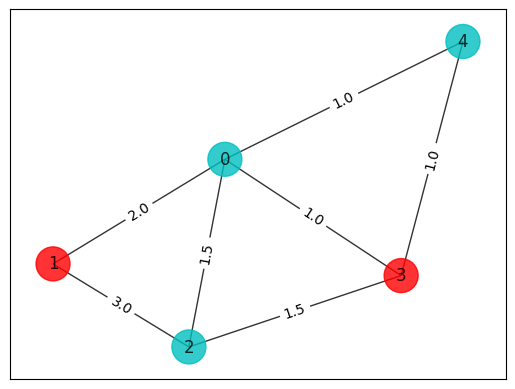

In [11]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ansatz = n_local(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=StatevectorSampler(seed=123), ansatz=ansatz, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

energy: -2.91796875
time: 1.3457005023956299
max-cut objective: -8.41796875
solution: [0 1 0 1 1]
solution objective: 8.5


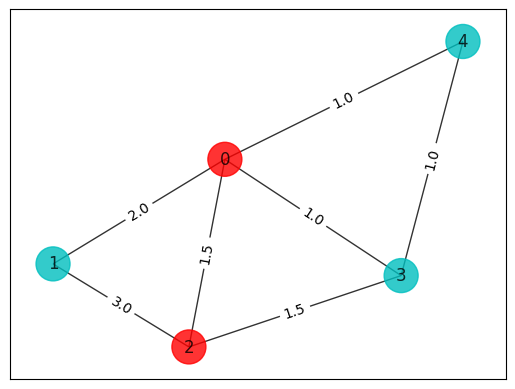

In [12]:
# construct SamplingVQE
optimizer = COBYLA(maxiter=300)
ansatz = RealAmplitudes(qubitOp.num_qubits, reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=StatevectorSampler(seed=123), ansatz=ansatz, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

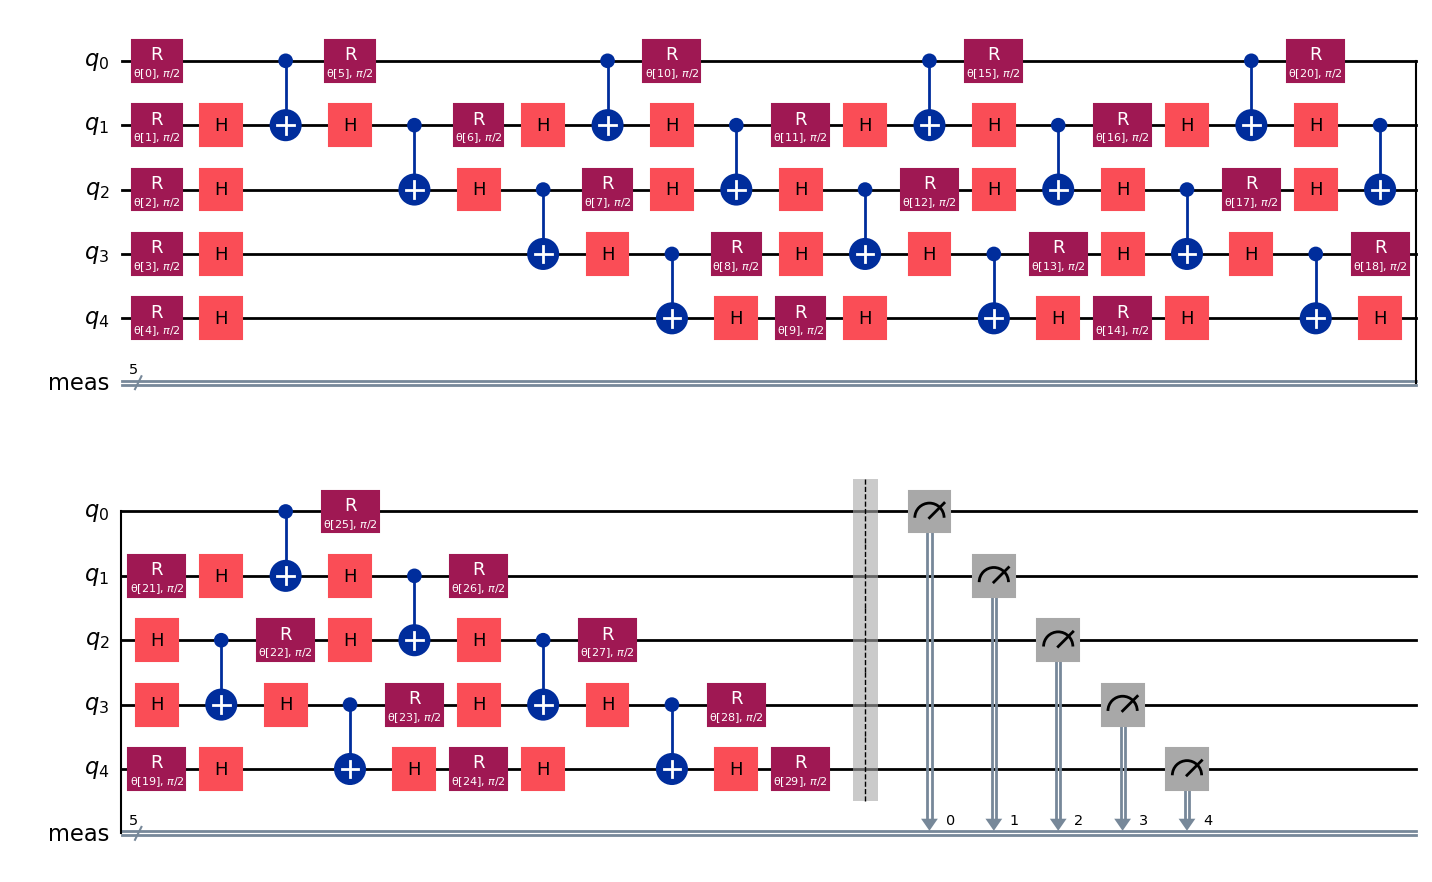

In [19]:
ansatz.decompose().draw('mpl', fold=20)

/Users/thiru/anaconda3/envs/qiskit_2.0/lib/python3.13/site-packages/qiskit/visualization/circuit/matplotlib.py:270: UserWarning: Style JSON file 'idx-dark.json' not found in any of these locations: /Users/thiru/anaconda3/envs/qiskit_2.0/lib/python3.13/site-packages/qiskit/visualization/circuit/styles/idx-dark.json, idx-dark.json. Will use default style.
  self._style, def_font_ratio = load_style(


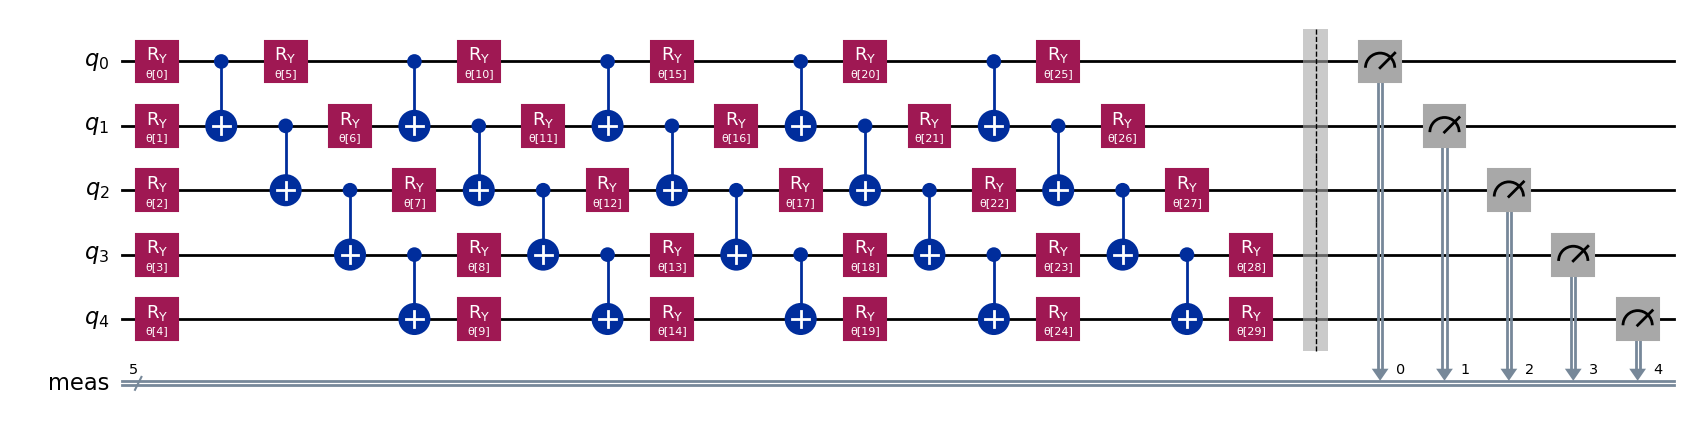

In [16]:
ra.decompose().draw('mpl', fold=30)